# Lab 07: Generative Adversarial Networks (GANs)

In this lab, we will develop several basic GANs and experiment with them.

Some of the information in this lab is based on material from Building Basic Generative Adversarial Networks (GANs) in Coursera.

## Generative Models vs Discriminative Models

Discriminative models are typically used for classification in machine learning.
Discriminative classifiers take a set of features $x$, such as having a nose or wheels,
and from these features determine a category $y$, 
meaning that they try to model the probability of class $y$ given the set of features $x$.
Assuming $X$ is a random variable over sets of features and $Y$ is a random variable over sets of possible classes,
a discriminative models estimates

$$D(x) = P(Y=y \mid X=x).$$

Generative models, however, model $P(x)$ or $P(x \mid y)$.
Generative models based on sampling take a random input and sometimes also a class $y$ such as a "dog."
From these inputs, a generative sampler will attempt to generate a set of features $x$ that are
representative of the class "dog." The random noise input ensures that we don't generate the same
dog each time.

Assuming random noise distribution $N$, a conditional sample-based generative model attempts
the following:

1. Input class $y$
2. $z \sim N$
3. $x = G(z,y)$

the goal is $P_{z\sim N}(G(z,y)=x) = P(x \mid y)$.


## Generative Adversarial Networks (GANS)

GANs for images are composed of two models, a generator that generates images
and a discriminator that is a discriminative classifier.
The generator takes in a random noise input and an optional class and
deterministically transforms the input into an image. The discriminator attempts to 
determine which of its inputs are real samples from the data distribution and which ones
are fake samples generated by the generator. Over time, the models compete. If the training is
set up well, when complete, the generator can take in any random noise input and produce a realistic result.
In summary, $G$ learns to produce realistic examples like an artist painting paintings that look like photos,
while $D$ distinguishes the painted photos from real photos.
The basic GAN model described by Goodfellow et al. (2014) looks like this:

<img src="img/gan_architecture-1.png" title="GAN Framework" style="width: 640px;" />

After this lab, you may be interested in reading about [6 GAN Architectures You Really Should Know](https://neptune.ai/blog/6-gan-architectures).

## Gan Setup

Let's build our first GAN.

There are about a million tutorials on coding GANs with PyTorch available online. We'll use
[code from GitHub user diegoalejogm](https://github.com/diegoalejogm/gans).

To run this code you'll need some dependencies such as tensorboardX:

In [1]:
!pip install tensorboardX

     |████████████████████████████████| 114 kB 464 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 98 kB/s eta 0:00:012


Here is a `Logger` class with useful tricks to indicate training progress and visualize results.

In [2]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

## Vanilla GAN for MNIST dataset

Next we'll download the MNIST dataset as a small dataset on which we can get things running quickly:

In [3]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets

DATA_FOLDER = './torch_data/VGAN/MNIST'
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load Dataset and attach a DataLoader

data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
num_batches = len(data_loader)

0.1%

100.0%


Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw


102.8%
9.9%


Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw



100.0%
112.7%


Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw



### Generator

The generator in a GAN is the model
you want to help achieve high performance.
A generator generates different objects because of the random noise sample.
If we make small changes to the noise, we should be able to see corresponding
small changes to the output. The generator is driven by a noise vector
sampled from a latent space (the domain of $p_z$) and transforms that
noise sample into an element of the domain of
$p_{data}$.

<img src="img/Generator.jpg" title="Generator" style="width: 640px;" />

The generator model can be practically anything that has the right input
and output tensor shapes. The "vanilla" GAN is the simplest GAN network architecture.
Here is the structure of a simple vanilla GAN generator using only
fully connected layers:

<img src="img/VanillaGAN-Gen.png" title="Generator model" style="width: 640px;" />

And here is sample code for the model's PyTorch Module. Note that since we
normalize the real-valued input data to the range [-1,1], to limit the generator to the
same range, we use a hyperbolic tangent activation at the output:

In [4]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

# Function to create noise samples for the generator's input

def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n

### Discriminator

The discriminator is a type of classifier, but it is just to classify its input as
real or fake.
When a fake sample from the generator is given, it should ouptut 0 for fake:

<img src="img/DiscriminatorFake.png" title="Discriminator-1" style="width: 640px;" />

On the other hand, if the input is real, it shoudl output 1 for real:

<img src="img/DiscriminatorReal.jpg" title="Discriminator-2" style="width: 640px;" />

We'll use the following simple discriminator structure:

<img src="img/VanillaGAN-Dis.png" title="VanillaGAN Discriminator" style="width: 640px;" />

Here is the Module:

In [5]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

### Create the modules

Let's create an instance of the generator and discriminator:

In [6]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

### Set up the optimizers

The optimization is a min-max game.
The generator wants to minimize the objective function, whereas the discriminator wants to maximize the same objective function.
The discriminator's loss function is binary cross entropy:

$$\mathcal{L}_D = \max_D\mathcal{L}(D;G)=\mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_x{z}}[\log (1-D(G(z))]$$

The generator does't affect the first term of $\mathcal{L}_D$, so its goal
is a bit simpler, to minimize the second term of $\mathcal{L}_D$:

$$\mathcal{L}_G = \min_G\mathcal{L}(G;D)=\mathbb{E}_{z \sim p_x{z}}[\log (D(G(z))]$$

Putting these together we have

$$\min_G\max_D\mathcal{L}(D;G)=\mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_x{z}}[\log (1-D(G(z))]$$

Here is a diagram of the objective function:

<img src="img/GanObjectivefunction.png" title="min-max optimization" style="width: 640px;" />


### Aside: why not select a very strong discriminator?

If we have a discriminator that is far superior to the generator, it will quickly determine that all the fake examples are 100% fake with
high confidence. That will not be very useful for the generator, which needs a signal to tell it how to make its samples look less fake.
On the other hand, if we have a generator that is far superior to the discriminator, we will get predictions indicating that both the real and
generated samples are equally likely to be real or fake. This is actually the end goal: a perfect generator. But we are unlikely to obtain a
perfect generator, and if the generator is not yet perfect, it is important to keep the generator and discriminator both improving together,
with similar "skill levels" from the beginning. Since the discriminator has an "easier" job than the generator, it will be difficult to keep
the competition balanced. We will talk about some solutions to this problem, such as WGANs, later.

OK, back to the optimizers.
From Goodfellow et al. (2014), the two networks are trained in an alternating fashion.
So it will be straightforward to have a separate optimizer for each model.

In [7]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 200

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

### Training

The targets for the discriminator may be 0 or 1 depending on whether we're giving it
real or fake data:

In [8]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

Here's a function for a single step for the discriminator:

In [9]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

And here's a function for a single step of the generator:

In [10]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

### Generate test noise samples

Let's generate some noise vectors to use as inputs to the generator.
We'll use these samples repeatedly to see the evolution of the generator
over time.

In [11]:
num_test_samples = 16
test_noise = noise(num_test_samples)

## Start training

Now let's train the model:

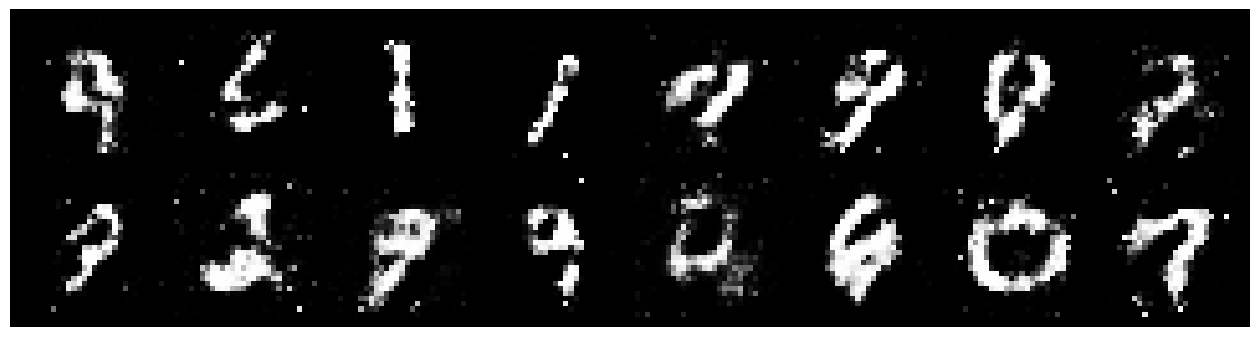

Epoch: [27/200], Batch Num: [300/600]
Discriminator Loss: 0.9962, Generator Loss: 1.3992
D(x): 0.6887, D(G(z)): 0.3478


KeyboardInterrupt: 

In [12]:
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # Train discriminator on a real batch and a fake batch
        
        real_data = images_to_vectors(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress

        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

## DCGAN for CIFAR

Our simple generator for MNIST was fully connected. While that worked
fine for MNIST, it would not work for more complex RGB images.

The DCGAN is a GAN with a generator
designed to do just that, generate larger RGB images using convolutional layers.

Here is the DCGAN architecture:

<img src="img/dcgan.png" title="DCGAN" style="width: 1080px;" />

### Load CIFAR10 data

For our DCGAN experiment, we'll use CIFAR rather than MNIST:

In [ ]:
DATA_FOLDER = './torch_data/DCGAN/CIFAR'

def cifar_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

data = cifar_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

### Networks

Here's another simpler picture of the DCGAN model structures:

<img src="img/dcgan2.png" title="DCGAN" style="width: 640px;" />

Here are PyTorch Modules for them:

In [ ]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

The generator is using transpose convolutions with batch normalization:

In [ ]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)


Let's create a generator and discriminator and initialize their weights: 

In [ ]:
# Custom weight initialization

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

# Instantiate networks

generator = GenerativeNet()
generator.apply(init_weights)
discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

### Optimizers

Next, we set up the optimizers and loss function.

In [ ]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# Number of epochs of training
num_epochs = 30

### Training

As before, we'll generate a fixed set of noise samples to see the evolution of the
generator over time then start training:

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

logger = Logger(model_name='DCGAN', data_name='CIFAR10')

for epoch in range(num_epochs):
    for n_batch, (real_data,_) in enumerate(data_loader):

        # Train Discriminator
        
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # Train Generator
        
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)

        # Log error and display progress
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)


## Conditional GANs

### Unconditional GANs

Until now, we know how to use GANs to generate some images. However, we never know what is the image classes which it generated. We call the GANs at above that **Unconditional GANs**.
The unconditional GANs may useful for creating some dataset, but it is not good that we don't know which images will be generated.

### Conditional GANs

From the problem above, we want the generator to generate the specific data more than randomize the output, so **conditional GANs** has been created to address it. Conditional generation allows you to get the sample from a specific class.

The thing you need for train the conditional GANs is **Labeled class**.

| Unconditional GANs  | Conditional GANs |
|:---:|:---:|
| Get random samples from **random classes** | Get random sample from **specific class** |
| Training dataset does **not require labeled classes**. | Training dataset **requires labeled classes**. |

### Using conditional GANs

In generator input, you need to add (concat) noise vector and **one-hot vector class** into the training as image below.

<img src="img/Conditional_generator.png" title="Conditional Generator" style="width: 800px;" />

In the same time, for discriminator, to tell discriminator that we must check the image with class, you need to add the one-hot vector class into the input of discriminator too.

<img src="img/Conditional_discriminator.png" title="Conditional Discriminator" style="width: 800px;" />

The coding is at below:

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

#### Create Generator and Noise vector

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

#### Create Discriminator

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Class Input

In conditional GANs, the input vector for the generator will also need to include the class information. The class is represented using a one-hot encoded vector where its length is the number of classes and each index represents a class. The vector is all 0's and a 1 on the chosen class. Given the labels of multiple images (e.g. from a batch) and number of classes.

In [ ]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels, n_classes)

Next, you need to be able to concatenate the one-hot class vector to the noise vector before giving it to the generator. You will also need to do this when adding the class channels to the discriminator.

In [ ]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    combined = torch.cat((x.float(), y.float()), dim=1)
    return combined

## Training
Now you can start to put it all together!
First, you will define some new parameters:

 - mnist_shape: the number of pixels in each MNIST image, which has dimensions 28 x 28 and one channel (because it's black-and-white) so 1 x 28 x 28
 - n_classes: the number of classes in MNIST (10, since there are the digits from 0 to 9)

In [ ]:
mnist_shape = (1, 28, 28)
n_classes = 10

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 1000
batch_size = 128
lr = 0.0002
device = 'cuda:1'

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Then, you can initialize your generator, discriminator, and optimizers. To do this, you will need to update the input dimensions for both models.

**For the generator**

you will need to calculate the size of the input vector; recall that for conditional GANs, the generator's input is the noise vector concatenated with the class vector.

**For the discriminator**

you need to add a channel for every class.

In [ ]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [ ]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

#### Train it!

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

#UNIT TEST NOTE: Initializations needed for grading
noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels, 
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        
        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

**Note**: If you got error on **RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED using pytorch**
It's mean that your CUDA version is not 11.2 or upper, so you need to install another torch version.

<code>pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html</code>

### Exploration
#### Changing the Class Vector
You can generate some numbers with your new model! You can add interpolation as well to make it more interesting.

So starting from a image, you will produce intermediate images that look more and more like the ending image until you get to the final image. Your're basically morphing one image into another. You can choose what these two images will be using your conditional GAN.

In [ ]:
gen = gen.eval()

import math

### Change me! ###
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

### Change me! ###
start_plot_number = 1 # Choose the start digit
### Change me! ###
end_plot_number = 5 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

### Uncomment the following lines of code if you would like to visualize a set of pairwise class 
### interpolations for a collection of different numbers, all in a single grid of interpolations.
### You'll also see another visualization like this in the next code block!
plot_numbers = [2, 3, 4, 5, 7]
n_numbers = len(plot_numbers)
plt.figure(figsize=(8, 8))
for i, first_plot_number in enumerate(plot_numbers):
    for j, second_plot_number in enumerate(plot_numbers):
        plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
        interpolate_class(first_plot_number, second_plot_number)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

#### Changing the Noise Vector
Now, what happens if you hold the class constant, but instead you change the noise vector? You can also interpolate the noise vector and generate an image at each step.

In [ ]:
n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
for i in range(10):
    #interpolation_label = get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()
    interpolation_label = get_one_hot_labels(torch.Tensor([i]).long(), n_classes).repeat(n_interpolation, 1).float()

    def interpolate_noise(first_noise, second_noise):
        # This time you're interpolating between the noise instead of the labels
        percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
        interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

        # Combine the noise and the labels again
        noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
        fake = gen(noise_and_labels)
        show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

    # Generate noise vectors to interpolate between
    ### Change me! ###
    #for n_noise in range(10):
    n_noise = 5 # Choose the number of noise examples in the grid
    plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
    plt.figure(figsize=(8, 8))
    for i, first_plot_noise in enumerate(plot_noises):
        for j, second_plot_noise in enumerate(plot_noises):
            plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
            interpolate_noise(first_plot_noise, second_plot_noise)
            plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
    plt.show()
    plt.close()

## Controllable Generation

Controllable generation allows you to control some of the features that you want in your output examples. For instance, with a gan that performs face generation, you could control the age of the person's looks in the image or if they have sunglasses or the direction they're looking at in the picture, or they're perceived gender. You can do this by actually tweaking the input noise vector Z, that is fed to the generator after you train the model. For example:
- Glasses
- Gender
- Age
- Hair color

<img src="img/Controllable_generation.png" title="Controllable generation" style="width: 640px;" />

### Controllable vs Conditional GANs

Controllable and conditional GANs are looked-a-like. Because some features are also can be a class, and sometime Controllable GANs also include conditional GANs in the network. However, there are some specific differences in there

| Controllable | Conditional |
|:---:|:---:|
| Generate the samples with features | Generate the sample with the specific class |
| Labeled data is not required | Require labeled data |
| Manipulate the z vector input | append a class vector to the input |

### Vector Z-Space

To control the output features from GANs, It is necessary to find the vector Z-space direction. Then, you can modify the output by moving the noise input vector in that known direction. 

<img src="img/Controllable_vectorz.png" title="Vector Z-space direction" style="width: 640px;" />

However, the Vector Z-space may have conflict with other features when the Z noise is too low data.
In the other hand, if the Z noise is too much, from "a normal woman" you may get "a woman with mustache" instead of "a man with mustache". Thus, you need to be carefule about tuning the feature parameter.

So to find the direction in the z-space that modifies certain features on the output, say the presence of sunglasses. Using a **train classifier that identifies features**. To do that, taking a batch of noise vector Z, that goes through the generator to get some images. For example, images through a sunglasses classifier, which will tell you at the outputs correspond to people with or without sunglasses.

To use them information to modify your Z vectors, and this is without modifying the weights of the generator at all. So **the generator weights are frozen**, and modifying only the Z vectors by moving in the direction of the gradient with the costs. 

<img src="img/Controllable_howto.png" title="" style="width: 640px;" />

### Let's Try

In this case, we are going to use [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset.

We have the pretrained weight of classifier and celebA in [the link](https://www.dropbox.com/sh/n593lmfeilgza14/AAAQylboARKi5DIJtX07o7pFa?dl=0).

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### Create generator and noise

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples in the batch, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Create classifier class

As we mention above, the important thing for controllabe GANs is using classifier to adjust vector z-space, so we need to create classifier class for support the pretrained dataset.

In [ ]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

#### Specify the parameters

In [ ]:
z_dim = 64
batch_size = 128
device = 'cuda:1'

## Train a Classifier

Training your own classifier with this code, but this project provides with a pretrained one later in the code, so it is not necessary for training again.

In [ ]:
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # You can run this code to train your own classifier, but there is a provided pretrained one.
    # If you'd like to use this, just run "train_classifier(filename)"
    # to train and save a classifier on the label indices to that filename.

    # Target all the classes, so that's how many the classifier will learn
    label_indices = range(40)

    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ## Visualization code ##
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

# Uncomment the last line to train your own classfier - this line will not work now.
# If you'd like to do this, you'll have to download it and run it, ideally using a GPU 
# train_classifier("filename")

## Loading the Pretrained Models
You will then load the pretrained generator and classifier using the following code. (If you trained your own classifier, you can load that one here instead.)

In [ ]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

## Training
Now you can start implementing a method for controlling your GAN!

For training, you need to write the code to update the noise to produce more of your desired feature. You do this by performing stochastic gradient ascent. You use stochastic gradient ascent to find the local maxima, as opposed to stochastic gradient descent which finds the local minima. Gradient ascent is gradient descent over the negative of the value being optimized. Their formulas are essentially the same, however, instead of subtracting the weighted value, stochastic gradient ascent adds it; it can be calculated by `new = old + (∇ old * weight)`, where ∇ is the gradient of `old`. You perform stochastic gradient ascent to try and maximize the amount of the feature you want. If you wanted to reduce the amount of the feature, you would perform gradient descent. However, in this assignment you are interested in maximize your feature using gradient ascent, since many features in the dataset are not present much more often than they're present and you are trying to add a feature to the images, not remove.

Given the noise with its gradient already calculated through the classifier, you want to return the new noise vector.

In [ ]:
def calculate_updated_noise(noise, weight):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
          so you can access the gradient of the output class with respect to the noise by using noise.grad
        weight: the scalar amount by which you should weight the noise gradient
    '''
    new_noise = noise + noise.grad * weight
    return new_noise

#### Generation
Now, you can use the classifier along with stochastic gradient ascent to make noise that generates more of a certain feature. In the code given to you here, you can generate smiling faces. Feel free to change the target index and control some of the other features in the list! You will notice that some features are easier to detect and control than others.

The list you have here are the features labeled in CelebA, which you used to train your classifier. If you wanted to control another feature, you would need to get data that is labeled with that feature and train a classifier on that feature.

In [ ]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

### Change me! ###
target_indices = feature_names.index("Male") # Feel free to change this value to any string from feature_names!

noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

### Entanglement and Regularization
You may also notice that sometimes more features than just the target feature change. This is because some features are entangled. To fix this, you can try to isolate the target feature more by holding the classes outside of the target class constant. One way you can implement this is by penalizing the differences from the original class with L2 regularization. This L2 regularization would apply a penalty for this difference using the L2 norm and this would just be an additional term on the loss function.

Here, you'll have to implement the score function: the higher, the better. The score is calculated by adding the target score and a penalty -- note that the penalty is meant to lower the score, so it should have a negative value.

For every non-target class, take the difference between the current noise and the old noise. The greater this value is, the more features outside the target have changed. You will calculate the magnitude of the change, take the mean, and negate it. Finally, add this penalty to the target score. The target score is the mean of the target class in the current noise.

In [ ]:
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    '''
    Function to return the score of the current classifications, penalizing changes
    to other classes with an L2 norm.
    Parameters:
        current_classifications: the classifications associated with the current noise
        original_classifications: the classifications associated with the original noise
        target_indices: the index of the target class
        other_indices: the indices of the other classes
        penalty_weight: the amount that the penalty should be weighted in the overall score
    '''
    # Steps: 1) Calculate the change between the original and current classifications (as a tensor)
    #           by indexing into the other_indices you're trying to preserve, like in x[:, features].
    #        2) Calculate the norm (magnitude) of changes per example.
    #        3) Multiply the mean of the example norms by the penalty weight. 
    #           This will be your other_class_penalty.
    #           Make sure to negate the value since it's a penalty!
    #        4) Take the mean of the current classifications for the target feature over all the examples.
    #           This mean will be your target_score.
    # Calculate the norm (magnitude) of changes per example and multiply by penalty weight
    distance = current_classifications[:, other_indices] - original_classifications[:, other_indices]
    other_class_penalty = -torch.norm(distance, dim=1).mean() * penalty_weight
    # Take the mean of the current classifications for the target feature
    target_score = current_classifications[:, target_indices].mean()
    return target_score + other_class_penalty

### Try again!

In [ ]:
fake_image_history = []
### Change me! ###
target_indices = feature_names.index("BlackHair") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

## Wasserstein GANs

### Mode collapse

When you are training multiple classes, there are multiple modes (multimodals) which the generator needs to be learned such as "1", "2", "3", and so on. If the generator has a task to create many classes from dataset, some classes are easier to generate. That will fool the discriminator easily. For example, in MNIST, number 1 can fool the discriminator, but number 3 cannot fool it. When the generator generates number 3, the discriminator will attack to the generator that it is fake but when the generator create number 1, the discriminator mostly say it is real. Thus, the generator will learn that "OK, if I create '1', I will get reward", then it will generate only number 1. That's is bias dataset creation called **Mode collapse**.

During this whole training process, the discriminator naturally is trying to delineate this real and fake distribution as much as possible, whereas the generator is trying to make the generated distribution look more like the reals.
However, let's take a step back again to the generator and discriminators roles. 
The discriminator needs to output just a single value prediction within zero and one.
Whereas the generator actually needs to produce a pretty complex output composed of multiple features to try and fool the discriminator, for example, an image.
As a result that discriminators job tends to be a little bit easier. That's why GANs may go to mode collapse. That is because the discriminator learns faster than the generator. Finally, the cost function from discriminato will go to nearly "one" then it will not tell anything to generator, it is called **vanishing gradients** problem.

### Wasserstein loss (W-loss)

To address the problem, we need to tune the learning of discriminator.

Normally, The loss function of normal GANs or **BCE loss** is
$$\mathcal{L} = \min_d \max_g -[\mathbb{E}(\log(d(x))) + \mathbb{E}(1-\log(d(g(z))))]$$

That is come out between 0 and 1.

The wasserstein loss or W-Loss approximates the Earth Mover's Distance. That is look similar to the simplified form for the BCE loss. In this case the function calculates the difference between the expected values of the predictions of the discriminator, that is called the critic, and $c$ of a real example $x$, versus $c$ of a fake example $g$ of $z$. Generator taking in a noise vector to produce a fake image $g$ of $z$, or x-hat $\hat{x}$.

$$\mathcal{L}_W = \min_d \max_c [\mathbb{E}(c(x)) + \mathbb{E}(c(g(z)))]$$

The different of BCE loss and W-loss are BCE loss can be satuated from sigmoid function, but W-loss is the output of linear function. Thus, W-loss is come out any real number.

<img src="img/WGANlosscompare.png" title="Loss function" style="width: 640px;" />

**Remark**: the right side should be **Critic output (W-GANs)** instead of *Discriminator output (W-GANs)*.

### Let's code!

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

#### Create Generator and Noise, again

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

### Create Critic class

Instead of create discriminator class, you must create critic class.

In [ ]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),  # Final Layer!!! difference from discriminator now
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## Training Initializations
Now you can start putting it all together.
As usual, you will start by setting the parameters:
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum terms
  *   c_lambda: weight of the gradient penalty
  *   crit_repeats: number of times to update the critic per generator update - there are more details about this in the *Putting It All Together* section
  *   device: the device type

You will also load and transform the MNIST dataset to tensors.

In [ ]:
n_epochs = 100
z_dim = 64
display_step = 5000
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda:1'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Then, you can initialize your generator, critic, and optimizers.

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

#### Gradient Penalty
Calculating the gradient penalty can be broken into two functions: (1) compute the gradient with respect to the images and (2) compute the gradient penalty given the gradient.

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        inputs = mixed_images,
        outputs= mixed_scores,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


The second function you need to complete is to compute the gradient penalty given the gradient. First, you calculate the magnitude of each image's gradient. The magnitude of a gradient is also called the norm. Then, you calculate the penalty by squaring the distance between each magnitude and the ideal norm of 1 and taking the mean of all the squared distances.

In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean(gradient_norm - 1) ** 2
    return penalty

### Losses
Next, you need to calculate the loss for the generator and the critic.

For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake images. The argument has the scores for all fake images in the batch, but you will use the mean of them.

In [ ]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = -1 * torch.mean(crit_fake_pred)
    return gen_loss

For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real images and the predictions on the fake images while also adding a gradient penalty. The gradient penalty is weighed according to lambda. The arguments are the scores for all the images in the batch, and you will use the mean of them.

In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = (torch.mean(crit_fake_pred) - torch.mean(crit_real_pred)) + c_lambda * gp
    return crit_loss

### Putting it all together!

1.   Even on GPU, the **training will run more slowly** because the gradient penalty requires you to compute the gradient of a gradient -- this means potentially a few minutes per epoch! For best results, run this for as long as you can while on GPU.
2.   One important difference from earlier versions is that you will **update the critic multiple times** every time you update the generator This helps prevent the generator from overpowering the critic. Sometimes, you might see the reverse, with the generator updated more times than the critic. This depends on architectural (e.g. the depth and width of the network) and algorithmic choices (e.g. which loss you're using). 
3.   WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just **increases stability** and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN from last assignment, though it will generally run a bit slower. You should also be able to train your model for more epochs without it collapsing.

If you have time, train for 25,000 steps. Good luck!


In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1


## Exercises

Do the following on your own:
1. Reproduce the vanilla GAN and DCGAN results on MNIST and CIFAR. Get the training and test loss for the generator and discriminator over time, plot them, and interpret them.
2. Develop your own GAN to model data generated as follows:
   $$ \begin{eqnarray} \theta & \sim & {\cal U}(0,2\pi) \\
                      r      & \sim & {\cal N}(0, 1) \\
                      \mathbf{x} & \leftarrow & \begin{cases} \begin{bmatrix} (10+r)\cos\theta \\ (10+r)\sin\theta + 10\end{bmatrix} & \frac{1}{2}\pi \le \theta \le \frac{3}{2}\pi \\ \begin{bmatrix} (10+r)\cos\theta \\ (10+r)\sin\theta - 10\end{bmatrix} & \mathrm{otherwise} \end{cases} \end{eqnarray} $$
   You should create a PyTorch DataSet that generates the 2D data in the `__init__()` method, outputs a sample in the `__getitem__()` method, and returns the
   dataset size in the `__len__()` method. Use the vanilla GAN approach above with an appropriate structure for the generator. Can your GAN generate a convincing
   facsimile of a set of samples from the actual distribution?
3. Use the DCGAN (or an improvement to it) to build a generator for a face image set of your choice. Can you get realistic faces that are not in the training set?

As always, submit a brief report documenting your experiments and results.
